In [1]:
import numpy as np
import pandas as pd
import math
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

In [2]:
%matplotlib inline  

In [3]:
mod = SourceModule("""
    #define N 1000
    
    
  
    
    
    __global__ void doIndexy(float *Z, int *indexx, int *indexy, float *pin, float *PYX,int total )
    { 
        
        int idx = blockIdx.x * blockDim.x + threadIdx.x; //this is actually j in indexy
        int t = 0; 
        if(idx >= total){
            return;
        }
        //printf("%d/n", total);
        float sum = 0;
        int j = indexy[idx]; 
        for (int i = 0; i < total ;i++){
           if(Z[indexx[i]+j-1]!=0.f){
               sum += 0.1*0.1*0.1*0.1*Z[indexx[i]+j-1]*log2(Z[indexx[i]+j-1]);
           }
           
           //printf("%d\\n", Z[0]);
        }; 
        //printf("%f/n", sum);
        PYX[idx] = sum; 
        
        //printf ("%d:::::::\\t", idx);
       
       // in[idx*(d+1)+5]=integral(in[idx*(d+1)+0],in[idx*(d+1)+1], in[idx*(d+1)+2], in[idx*(d+1)+3], in[idx*(d+1)+4]);
    }""")
mod2 = SourceModule("""

    __global__ void doIndexx(float *Z, int *indexx, int *indexy, float *pin, float *PY,int total )
    { 
        
        int idx = blockIdx.x * blockDim.x + threadIdx.x; //this is actually j in indexy
        //printf("%d\\n", idx);
        int t = 0; 
        //if(idx >= total){
          //  return;
        //}
        //printf("%d/n", total);
       float sum = 0;
       int j = indexx[idx]; 
       for (int i = 0; i < total ;i++){
           //if(Z[indexy[i]+j-1]!=0.f){
         sum += 0.1*0.1*0.1*0.1*Z[indexy[i]+j-1]*pin[i];
               
               
           //}
           
           //printf("%d\\n", Z[0]);
        }; 
        //printf("%f/n", sum);
        PY[idx] = sum; 
        //PY[idx] = idx; 
        
        //printf ("%d:::::::\\t", idx);
       
       // in[idx*(d+1)+5]=integral(in[idx*(d+1)+0],in[idx*(d+1)+1], in[idx*(d+1)+2], in[idx*(d+1)+3], in[idx*(d+1)+4]);
    }""")


In [4]:
# In[3]:
# for benchmark
start = cuda.Event()
end = cuda.Event()

In [5]:
funcxy = mod.get_function("doIndexy")
funcxx = mod2.get_function("doIndexx")

In [6]:
inP_point=21
obs_point=61
Z_point=81
bbin = 0.1


In [7]:
# Z = np.random.randn(25,3)
# Z = np.abs(Z)

In [8]:
Z = pd.read_csv('input/savedist_5d_4_10.tsv',sep=' ',squeeze=True,header=None).values

In [9]:
# for N=3 
def in_dist(a,b,tau=1):
    ps = np.empty(len(a))
    for i in range(len(a)):
        if(b[i] >= a[i]):
            ps[i] = (1/tau**2)*(math.exp(-1*b[i]/tau))
        else: 
            ps[i] = 0
    return ps
            

In [10]:
# for N=4
def in_dist4(a,b,c,tau=1):
    ps = np.empty(len(a))
    for i in range(len(a)):
        if(b[i] >= a[i] and c[i] >= a[i] and c[i] >= b[i]):
            ps[i] = (1/tau**3)*(math.exp(-1*c[i]/tau))
        else: 
            ps[i] = 0
    return ps

In [11]:
# for N=4
def in_dist5(a,b,c,d,tau=1):
    ps = np.empty(len(a))
    for i in range(len(a)):
        if(d[i]>=a[i] and d[i]>=b[i] and d[i]>=c[i] and b[i] >= a[i] and c[i] >= a[i] and c[i] >= b[i]):
            ps[i] = (1/tau**4)*(math.exp(-1*d[i]/tau))
        else: 
            ps[i] = 0
    return ps

In [12]:
x, y ,z, w = np.meshgrid([x for x in np.arange(0,inP_point*bbin,bbin)],[x for x in np.arange(0,inP_point*bbin,bbin)],[x for x in np.arange(0,inP_point*bbin,bbin)],[x for x in np.arange(0,inP_point*bbin,bbin)])
# x, y = np.meshgrid([x for x in np.arange(0,2,1)],[x for x in np.arange(0,2,1)])

In [13]:
x = np.reshape(x,-1)
y = np.reshape(y,-1)
z = np.reshape(z,-1)
w = np.reshape(w,-1)


In [14]:
x[400:500]

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1])

In [15]:
pin = in_dist5(y,x,z,w, 0.5)
pin = pin.T

In [16]:
21**4

194481

In [17]:
indexy = np.array([],dtype=int)
for k in range (1,inP_point+1):
    for k1 in range (1,inP_point+1):
        for k2 in range (1, inP_point+1):
            a = [i for i in range(1+(Z_point*Z_point*Z_point*(k-1))+(Z_point*Z_point*(k1-1))+(Z_point*(k2-1)),
                                  (inP_point+1+(Z_point*Z_point*Z_point*(k-1))+(Z_point*Z_point*(k1-1))+(Z_point*(k2-1))))] ### possible index error
            indexy =np.append(indexy,a)


In [18]:
obs_point

61

In [19]:
indexy

array([       1,        2,        3, ..., 10761679, 10761680, 10761681])

In [20]:
indexx = np.empty(61**4,dtype=int)

for k in range (0,obs_point):
    print(k)
    for k1 in range (0,obs_point): 
        for k2 in range (0, obs_point):
            
            a = [i for i in range((Z_point*Z_point*Z_point*k)+(k1*Z_point*Z_point)+(k2*Z_point),
                              (Z_point*Z_point*Z_point*k)+(k1*Z_point*Z_point)+(k2*Z_point)+obs_point)] ### possible index error
            
            indexx[61**3*k+61**2*k1+61*k2:61**3*k+61**2*k1+61*k2+61] =a

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [22]:
indexx

array([       0,        1,        2, ..., 32285038, 32285039, 32285040])

In [23]:
indexx+indexy[-1]

array([10761681, 10761682, 10761683, ..., 43046719, 43046720, 43046721])

In [24]:
PYX = np.empty(len(indexy),np.float32)
PY = np.empty(len(indexx),np.float32)

In [25]:
PY.shape

(13845841,)

count = 0
for j in indexy:
    A = Z[indexx+j-1]
    
    PYX [count] = bbin**3*np.sum(A*np.log2(A))
    count = count + 1

count = 0
for j in indexx:
    B = Z[indexy+j-1]
    PY [count] = bbin**3*np.sum(B*pin)
    count = count + 1

In [26]:
# PYX

In [27]:
# PY

In [28]:
Z_2 = Z

In [29]:
d_Z_2 = cuda.mem_alloc(np.float32(Z_2).nbytes)
cuda.memcpy_htod(d_Z_2, np.float32(Z_2))

d_indexx = cuda.mem_alloc(np.int32(indexx).nbytes)
cuda.memcpy_htod(d_indexx, np.int32(indexx))

d_indexy = cuda.mem_alloc(np.int32(indexy).nbytes)
cuda.memcpy_htod(d_indexy, np.int32(indexy))

d_pin = cuda.mem_alloc(np.float32(pin).nbytes) 
cuda.memcpy_htod(d_pin, np.float32(pin))

d_PYX = cuda.mem_alloc(np.float32(PYX).nbytes) 
cuda.memcpy_htod(d_PYX, np.float32(PYX))




In [30]:
# for doIndexx
d_PY = cuda.mem_alloc(np.float32(PY).nbytes) 
cuda.memcpy_htod(d_PY, np.float32(PY))

In [31]:
start.record()


In [32]:
blocksize = 16
gridsize = math.floor(len(indexy)/blocksize)+1
funcxy(d_Z_2, d_indexx, d_indexy, d_pin, d_PYX, np.int32(len(indexx)),  block=(blocksize,1,1), grid =(gridsize,1,1))

In [33]:

h_PYX = np.zeros(len(indexy), np.float32)


In [34]:
cuda.memcpy_dtoh(h_PYX, d_PYX)

In [35]:

end.record()
end.synchronize()
secs = start.time_till(end)*1e-3
# print ("N :",total)
# print ("D :",d)
print ("%fs sec" % (secs))

260.801828s sec


In [36]:
start.record()

In [37]:
blocksize = 128
gridsize = math.floor(len(indexx)/blocksize)+1
print (gridsize)
funcxx(d_Z_2, d_indexx, d_indexy, d_pin, d_PY, np.int32(len(indexy)),  block=(blocksize,1,1), grid =(gridsize,1,1))

108171


In [38]:
h_PY = np.zeros(len(indexx), np.float32)

In [39]:
cuda.memcpy_dtoh(h_PY, d_PY)

In [40]:
end.record()
end.synchronize()
secs = start.time_till(end)*1e-3
# print ("N :",total)
# print ("D :",d)
print ("%fs sec" % (secs))

176.018453s sec


In [41]:
# pd.DataFrame(h_PYX)

In [42]:
len(indexy)

194481

In [43]:
h_PY[68916:68929]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

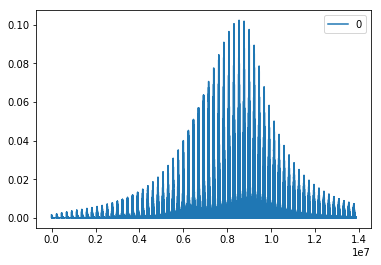

In [44]:
pd.DataFrame(h_PY).plot()

In [49]:
hy = bbin**4*np.sum(-1*h_PY[h_PY>0]*np.log2(h_PY[h_PY>0]))

In [50]:
hy

5.9547640625000007

In [51]:
hyc = -bbin**4*np.sum(pin*h_PYX.T)

In [52]:
hyc

5.1428601021408316